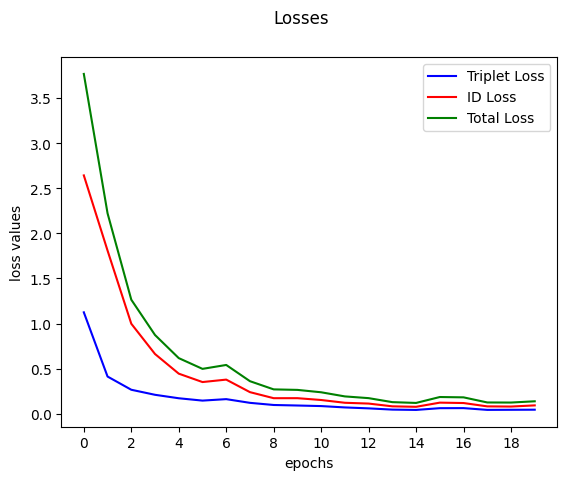

In [2]:
import os
import torch
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"]='True'   # I've problem with plt and this resolves.
from matplotlib import pyplot as plt

res_dir = os.path.join("results")

losses_path = os.path.join(res_dir, "losses.pth")
losses = torch.load(losses_path).numpy()

fig, ax = plt.subplots(1,1)
fig.suptitle("Losses")
ax.plot(losses[0], 'b-', label='Triplet Loss')
ax.plot(losses[1], 'r-', label='ID Loss')
ax.plot(losses[2], 'g-', label='Total Loss')
ax.legend(loc='upper right')
ax.set_xlabel("epochs")
ax.set_ylabel("loss values")
ax.set_yscale("linear")
plt.xticks(np.arange(0, losses.shape[1], 2))
plt.savefig(os.path.join(res_dir, "losses_graph.jpg"))
plt.show()


